# Интернет-магазин «В один клик»

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи:** построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных:**

Даны четыре датасета.

`market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

`market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

**План:**
1. Загрузка данных (#par1)
2. Предобработка данных(#par2)
3. Исследовательский анализ данных(#par3)
4. Объединение таблиц(#par4)
5. Корреляционный анализ(#par5)
6. Использование пайплайнов(#par6)
7. Анализ важности признаков(#par7)
8. Сегментация покупателей(#par8)
9. Общий вывод(#par9)

In [1]:
!pip install phik -q
!pip install shap==0.44.0  -q
!pip install scikit-learn==1.3.2 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

<a id='par1'></a> 
## Загрузка данных

In [3]:
market_file = pd.read_csv('C:/FATHER/datasets/market_file.csv')
market_money = pd.read_csv('C:/FATHER/datasets/market_money.csv')
market_time = pd.read_csv('C:/FATHER/datasets/market_time.csv')
money = pd.read_csv('C:/FATHER/datasets/money.csv', sep=';', decimal=',')

In [4]:
def description(df):
    display(df.head())
    df.info()

In [5]:
description(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
description(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
description(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
description(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод:** Все данные соответствуют описанию. Все признаки имеют верный тип данных. На этом этапе пропусков в данных не выявлено.

<a id='par2'></a> 
## Предобработка данных

### Поиск дубликатов

#### Датасет market_file

Проверим нет ли в категориальных признаков одинаковых значений или ошибок. Если есть, исправим все неточности.

In [9]:
cat_name = ['Покупательская активность','Тип сервиса','Разрешить сообщать','Популярная_категория']

for col in cat_name:
    print(col, market_file[col].unique())

Покупательская активность ['Снизилась' 'Прежний уровень']
Тип сервиса ['премиум' 'стандартт' 'стандарт']
Разрешить сообщать ['да' 'нет']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В признаке `Тип сервиса` повторяется значение "стандарт", в признаке `Популярная_категория` в одном из значений неправильно написано слово "аксессуары".

In [10]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт',
                                                                'стандарт', regex=True)
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace('Косметика и аксесуары',
                                                                                  'Косметика и аксессуары', regex=True)

for col in ['Тип сервиса','Популярная_категория']:
    print(col, market_file[col].unique())

Тип сервиса ['премиум' 'стандарт']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Проверим нет ли в данных нескольких строчек с данными одного и того же пользователя.

In [11]:
market_file.duplicated('id').sum()

0

Зададим индексы столбцом `id`.

In [12]:
market_file = market_file.set_index('id')
market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


#### Датасет market_money

Проверим категориальный признак `Период` на отсутствие похожих значений.

In [13]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Значения в признаке не повторяются. Посмотрим на наличие повторяющихся id

In [14]:
market_money.duplicated('id').sum()

2600

Заменим индексы на значения `id`.

In [15]:
market_money = market_money.set_index('id')
market_money.head()

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


#### Датасет market_time

Проверим категориальный признак `Период` на отсутствие похожих значений или ошибок.

In [16]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В слове "предыдущий" допущена ошибка, исправим ее.

In [17]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц', regex=True)
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Проверим на наличие повторяющихся id.

In [18]:
market_time.duplicated('id').sum()

1300

Заменим индексы на значения `id`.

In [19]:
market_time = market_time.set_index('id')
market_time.head()

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13


#### Датасет money

Проверим нет ли в этом датасете повторяющихся id. И заменим индексы на значения `id`.

In [20]:
money.duplicated('id').sum()

0

In [21]:
money = money.set_index('id')
money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


### Переименование столбцов

Переименуем столбцы в `market_file`, чтобы они все соответствовали одному стилю

In [22]:
market_file.columns

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [23]:
market_file = market_file.rename(columns={'Покупательская активность':'Покупательская_активность',
                                          'Тип сервиса':'Тип_сервиса',
                                          'Разрешить сообщать':'Разрешить_сообщать'})

In [24]:
market_file.columns

Index(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

**Вывод:** Мы нашли ошибки в некоторых значениях и исправили их. Дубликатов в данных обнаружено не было.

<a id='par3'></a> 
## Исследовательский анализ данных

### Датасет market_file

Исследуем все признаки.

In [25]:
c1 = market_file['Покупательская_активность'].value_counts()
c1

Прежний уровень    802
Снизилась          498
Name: Покупательская_активность, dtype: int64

In [26]:
c2 = market_file['Тип_сервиса'].value_counts()
c2

стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64

In [27]:
c3 = market_file['Разрешить_сообщать'].value_counts()
c3

да     962
нет    338
Name: Разрешить_сообщать, dtype: int64

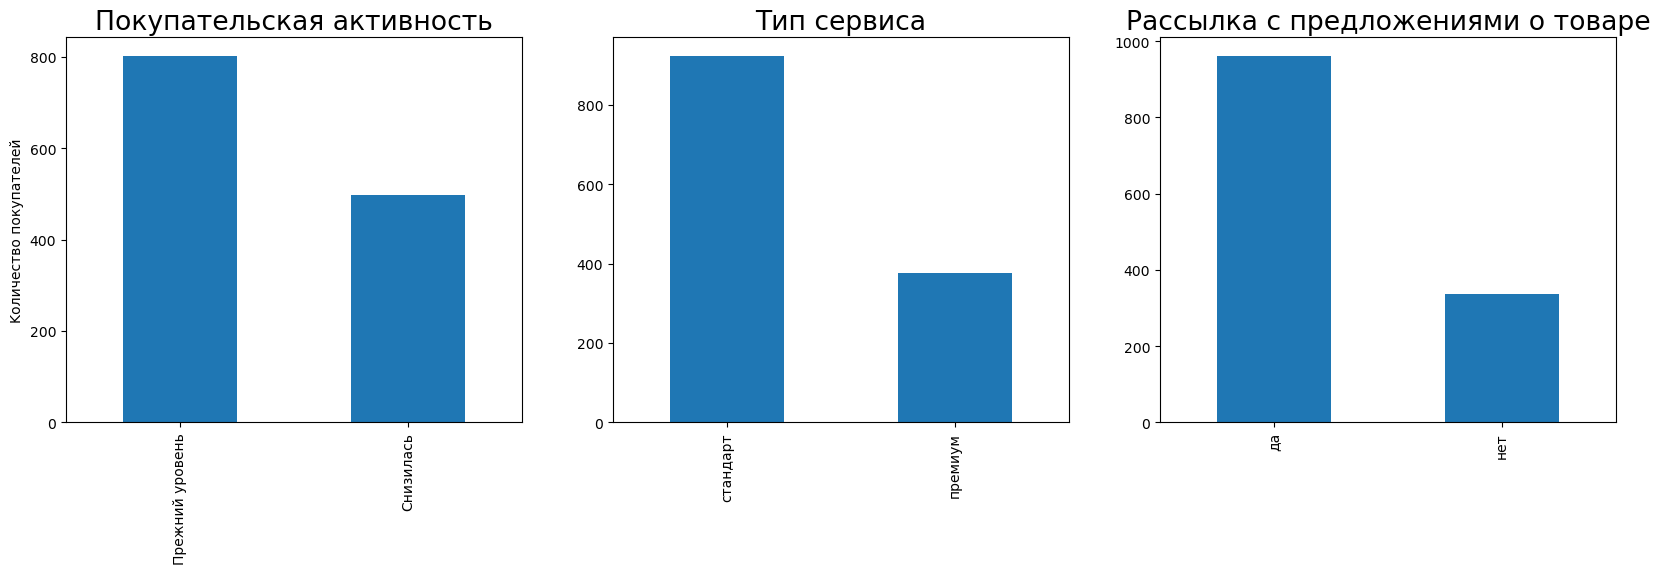

In [28]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '16'

c1.plot(kind='bar',ax=axs[0])
axs[0].set_title('Покупательская активность')
axs[0].set_ylabel('Kоличество покупателей')

c2.plot(kind='bar',ax=axs[1])
axs[1].set_title('Тип сервиса')

c3.plot(kind='bar',ax=axs[2])
axs[2].set_title('Рассылка с предложениями о товаре')

plt.show()

Покупательская активность снизилась у трети покупателей. Большинство пользуются стандартным сервисом и согласны на рассылку предложений.

Посмотрим на маркетинговую активность за 6 месяцев и за текущий.

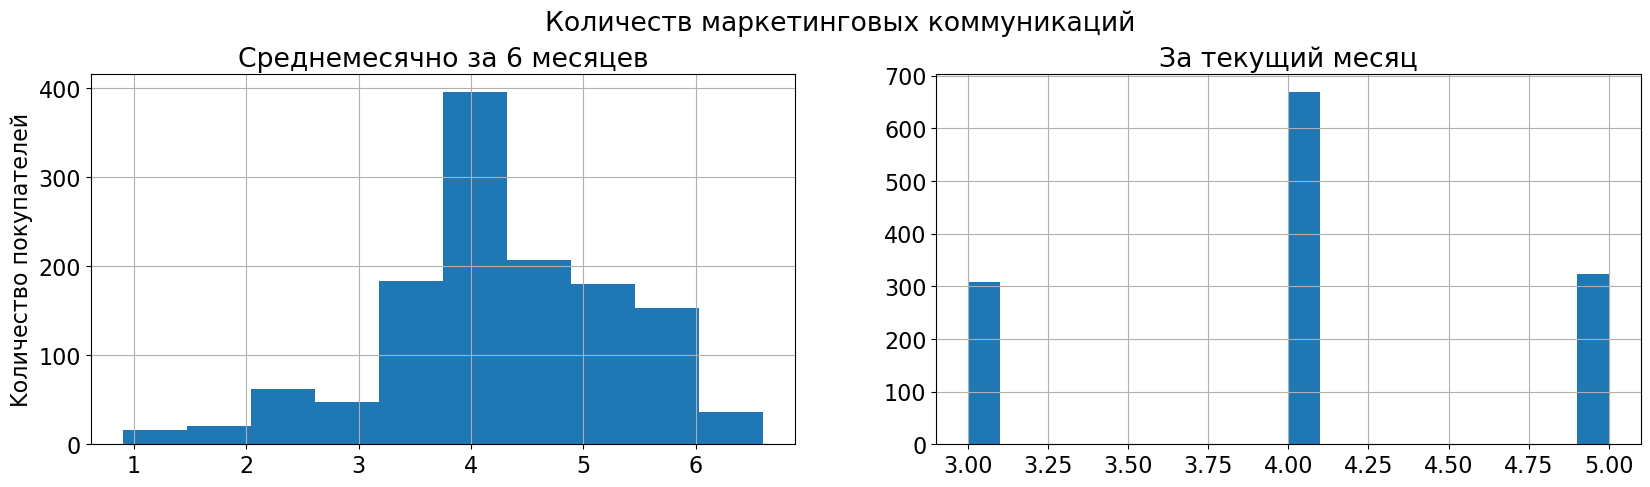

In [29]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

market_file['Маркет_актив_6_мес'].hist(bins=10,ax=axs[0])
axs[0].set_title('Среднемесячно за 6 месяцев')
axs[0].set_ylabel('Kоличество покупателей')

market_file['Маркет_актив_тек_мес'].hist(bins=20,ax=axs[1])
axs[1].set_title('За текущий месяц')

fig.suptitle('Количеств маркетинговых коммуникаций')
plt.subplots_adjust(top= 0.85 )
plt.show()

Количество маркетинговых коммуникаций за текущий месяц не меньше 3, хотя за 6 месяцев показатель опускался ниже 3.

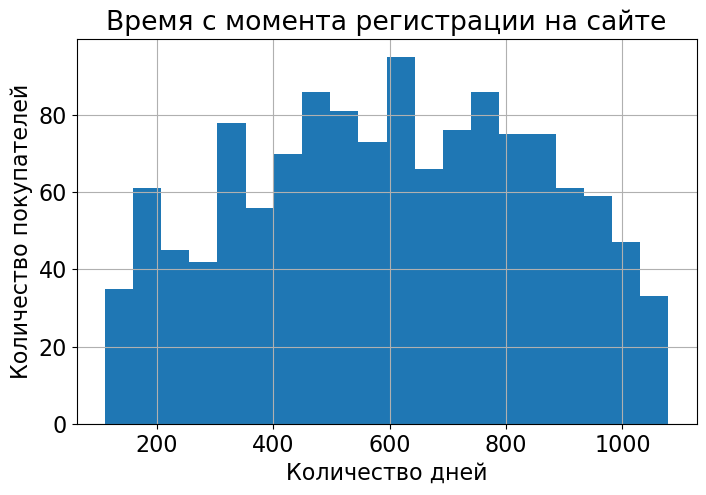

In [30]:
market_file['Длительность'].hist(bins=20,figsize=(8,5))

plt.title('Время с момента регистрации на сайте')
plt.xlabel('Количество дней')
plt.ylabel('Количество покупателей')
plt.show()

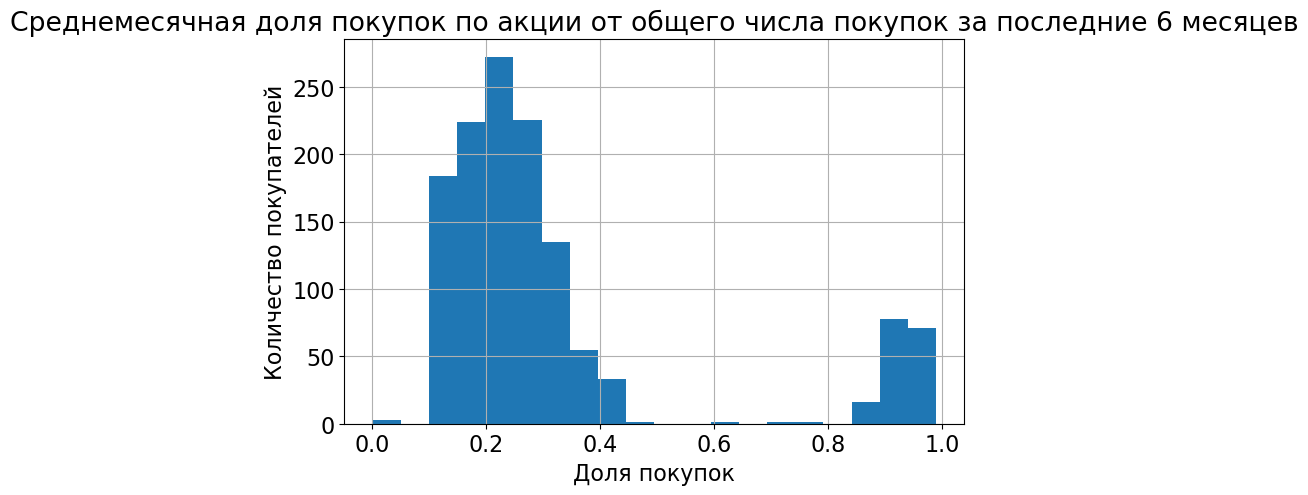

In [31]:
market_file['Акционные_покупки'].hist(bins=20,figsize=(8,5))

plt.title('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.xlabel('Доля покупок')
plt.ylabel('Количество покупателей')
plt.show()

По графику видно, что покупатели разделяются на две группы: те, кто большинство товаров покупают по скидке и те, кто наоборот.

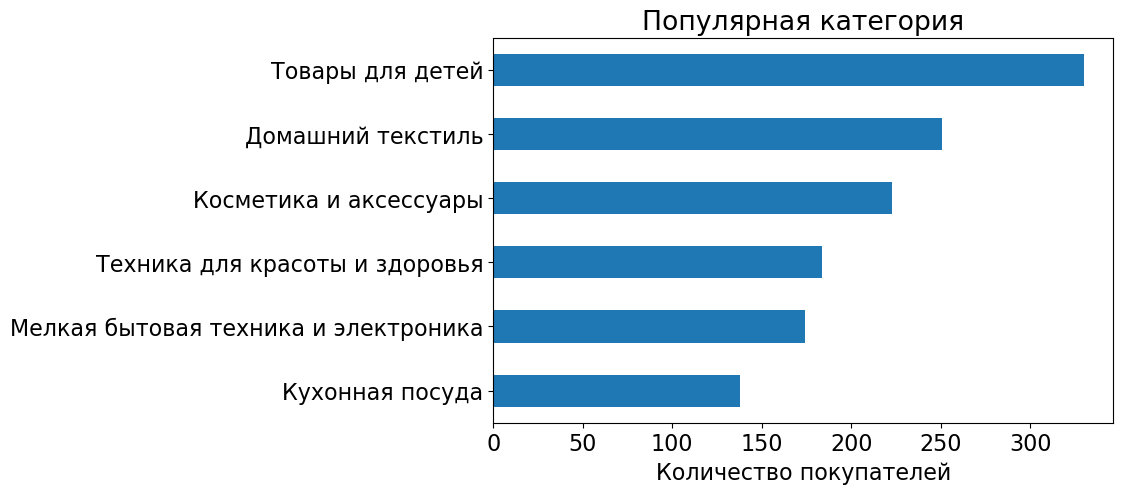

In [32]:
market_file['Популярная_категория'].value_counts().sort_values().plot(kind='barh',figsize=(8,5))

plt.title('Популярная категория')
plt.xlabel('Количество покупателей')
plt.show()

Больше всего пользователей заинтересованы в категории "товары для детей".

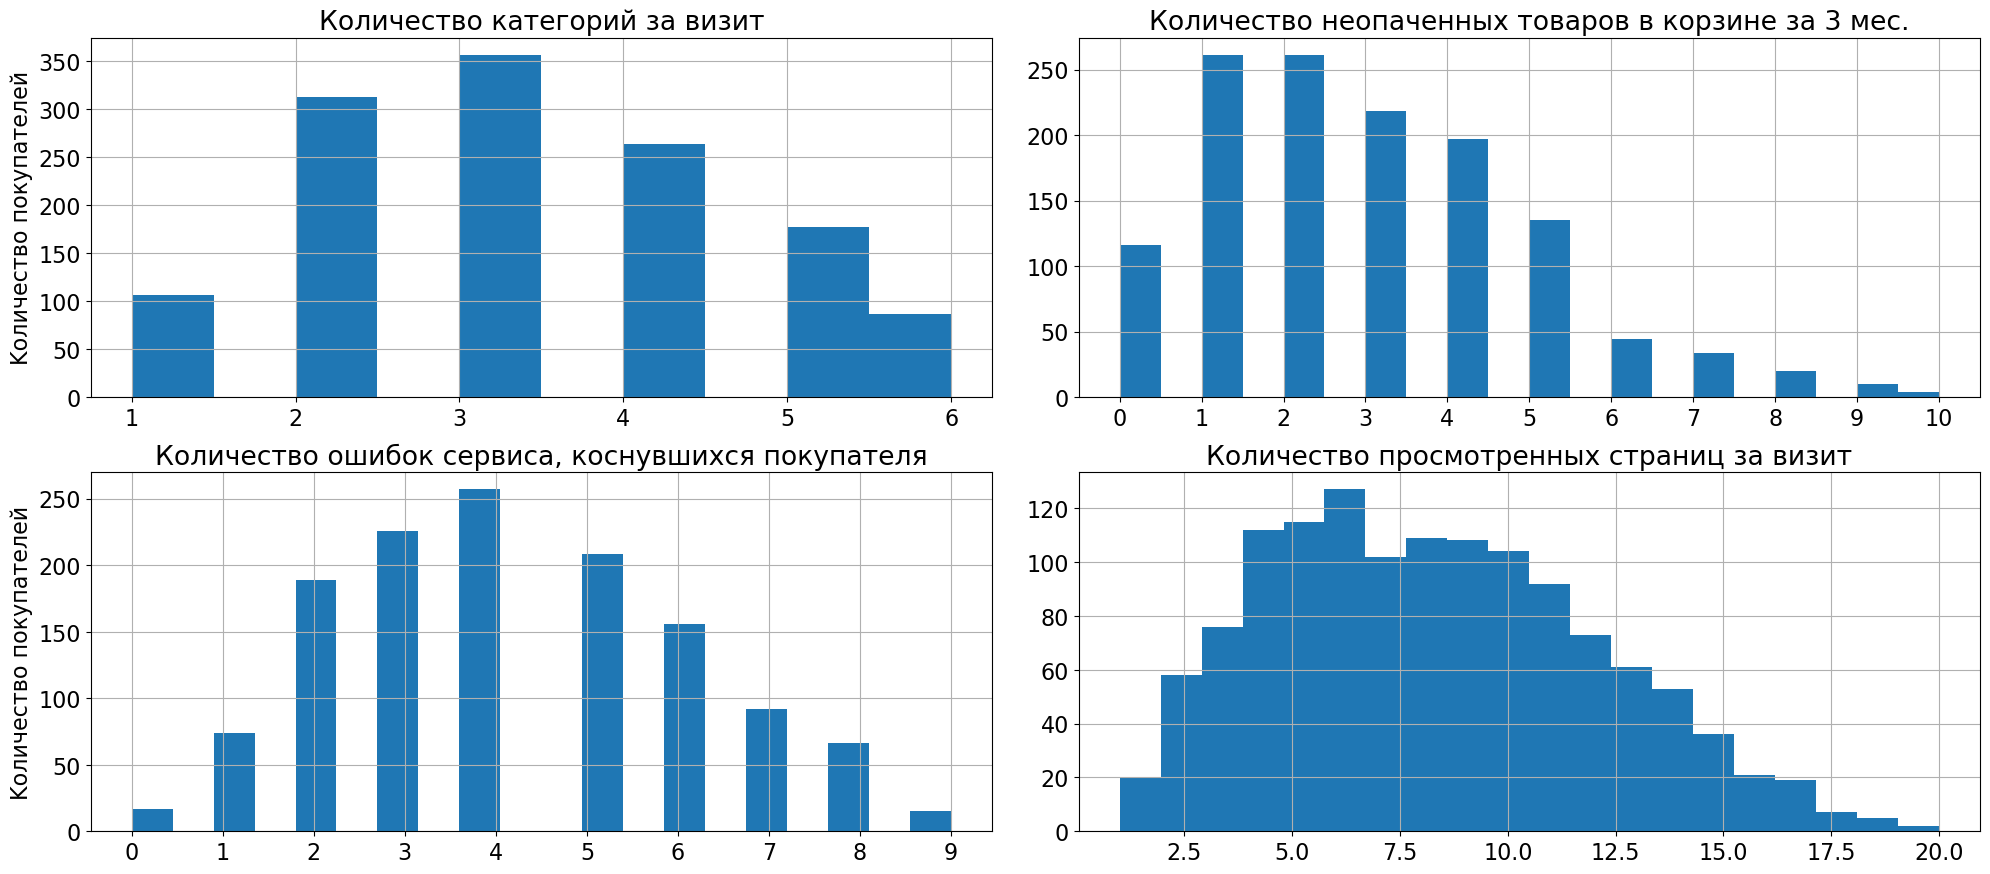

In [33]:
fig, axs = plt.subplots(nrows= 2 , ncols= 2 )
fig.set_size_inches(20, 10)
fig.tight_layout(h_pad= 2)

market_file['Средний_просмотр_категорий_за_визит'].hist(bins=10,ax=axs[0,0])
axs[0,0].set_title('Количество категорий за визит')
axs[0,0].set_ylabel('Kоличество покупателей')

market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=20,ax=axs[0,1])
axs[0,1].set_title('Количество неопаченных товаров в корзине за 3 мес.')
axs[0,1].set_xticks(market_file['Неоплаченные_продукты_штук_квартал'].unique())

market_file['Ошибка_сервиса'].hist(bins=20,ax=axs[1,0])
axs[1,0].set_title('Количество ошибок сервиса, коснувшихся покупателя')
axs[1,0].set_ylabel('Kоличество покупателей')
axs[1,0].set_xticks(market_file['Ошибка_сервиса'].unique())

market_file['Страниц_за_визит'].hist(bins=20,ax=axs[1,1])
axs[1,1].set_title('Количество просмотренных страниц за визит')

plt.subplots_adjust(top= 0.85 )
plt.show()

Все значения на графиках нормально распределены.

### Датасет market_money

Проверим одинаковое ли количество данных за каждый период.

In [34]:
market_money['Период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

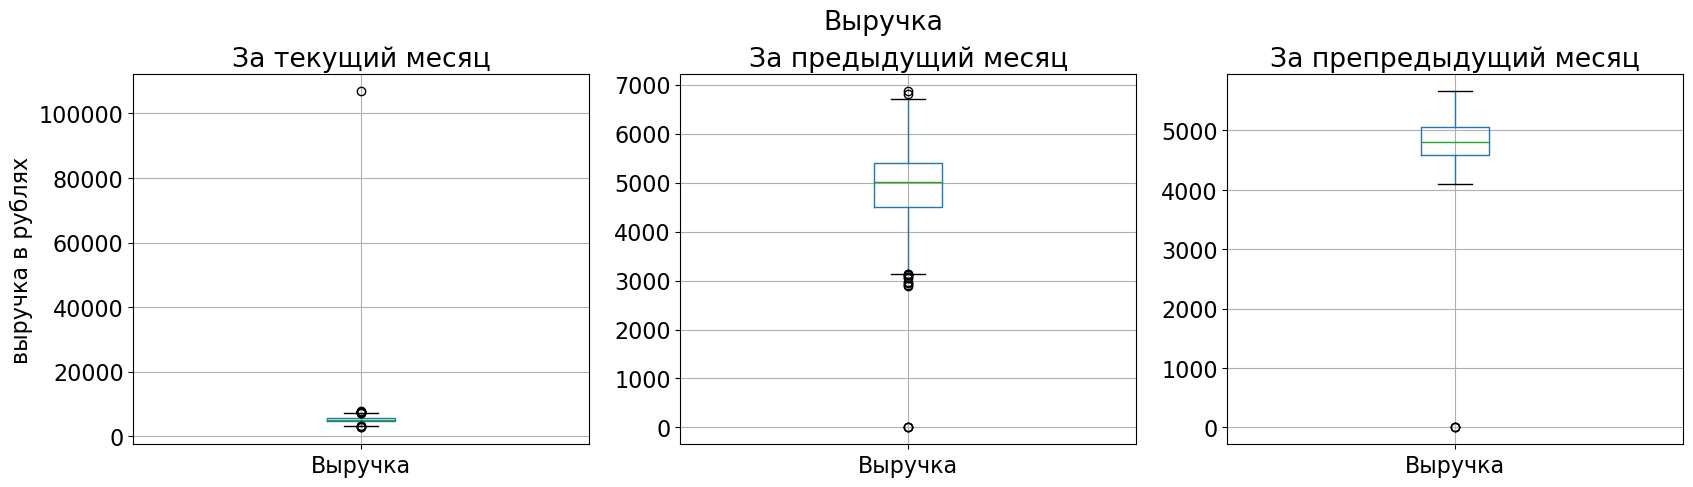

In [35]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)

market_money[market_money['Период']=='текущий_месяц'].boxplot(ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('выручка в рублях')

market_money[market_money['Период']=='предыдущий_месяц'].boxplot(ax=axs[1])
axs[1].set_title('За предыдущий месяц')


market_money[market_money['Период']=='препредыдущий_месяц'].boxplot(ax=axs[2])
axs[2].set_title('За препредыдущий месяц')

fig.suptitle('Выручка')
plt.subplots_adjust(top= 0.85 )
plt.show()

Выбросы в таких данных естественны и нормальны, удалять их не надо. За текущий месяц один покупатель совершил покупку на сумму больше 100000, при построении гистограммы не будем это учитывать для наглядности.

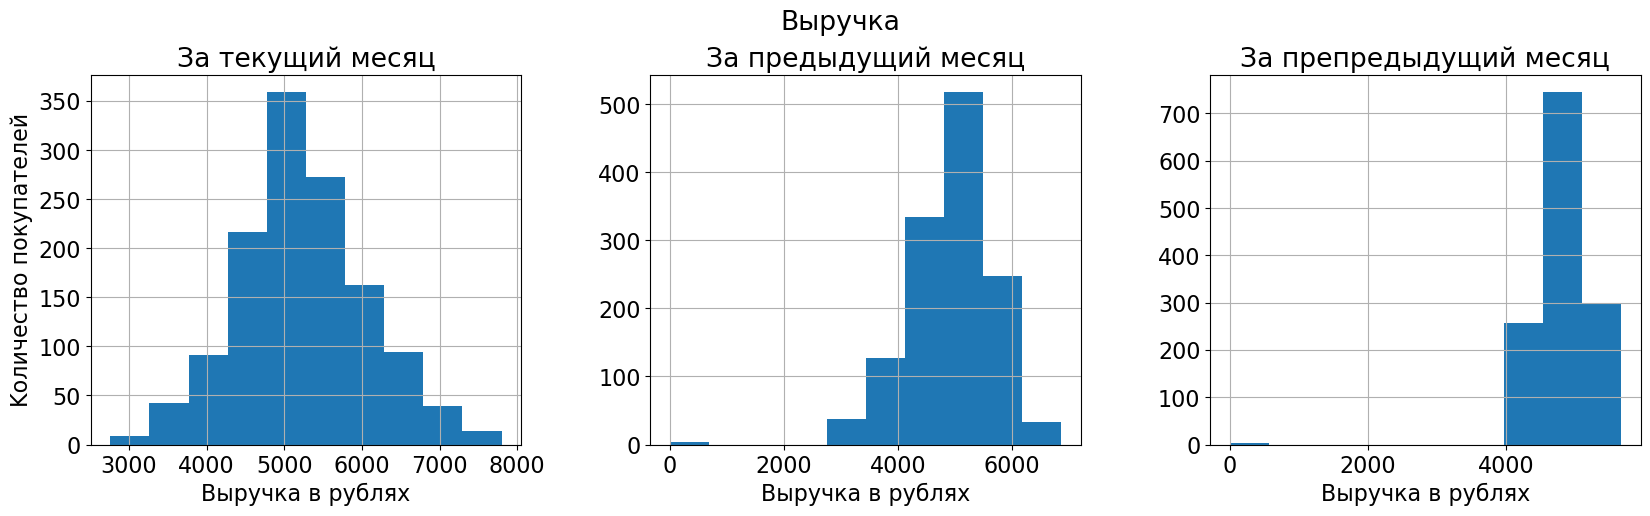

In [36]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)

market_money.loc[(market_money['Период']=='текущий_месяц')&(market_money['Выручка']<100000)].hist(bins=10,ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('Kоличество покупателей')
axs[0].set_xlabel('Выручка в рублях')

market_money[market_money['Период']=='предыдущий_месяц'].hist(bins=10,ax=axs[1])
axs[1].set_title('За предыдущий месяц')
axs[1].set_xlabel('Выручка в рублях')

market_money[market_money['Период']=='препредыдущий_месяц'].hist(bins=10,ax=axs[2])
axs[2].set_title('За препредыдущий месяц')
axs[2].set_xlabel('Выручка в рублях')

fig.suptitle('Выручка')
plt.subplots_adjust(top= 0.85 )
plt.show()

За текущий месяц не было неи одного покупателя, которых хоть что-нибудь бы не купил.

### Датасет market_time

In [37]:
market_time['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

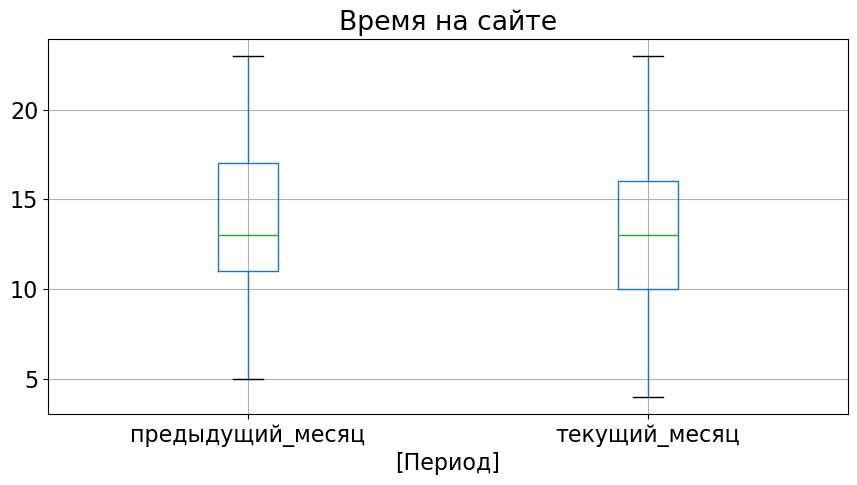

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
market_time.boxplot(by='Период', ax=ax)
ax.set_title('Время на сайте')

plt.suptitle('')
plt.show()

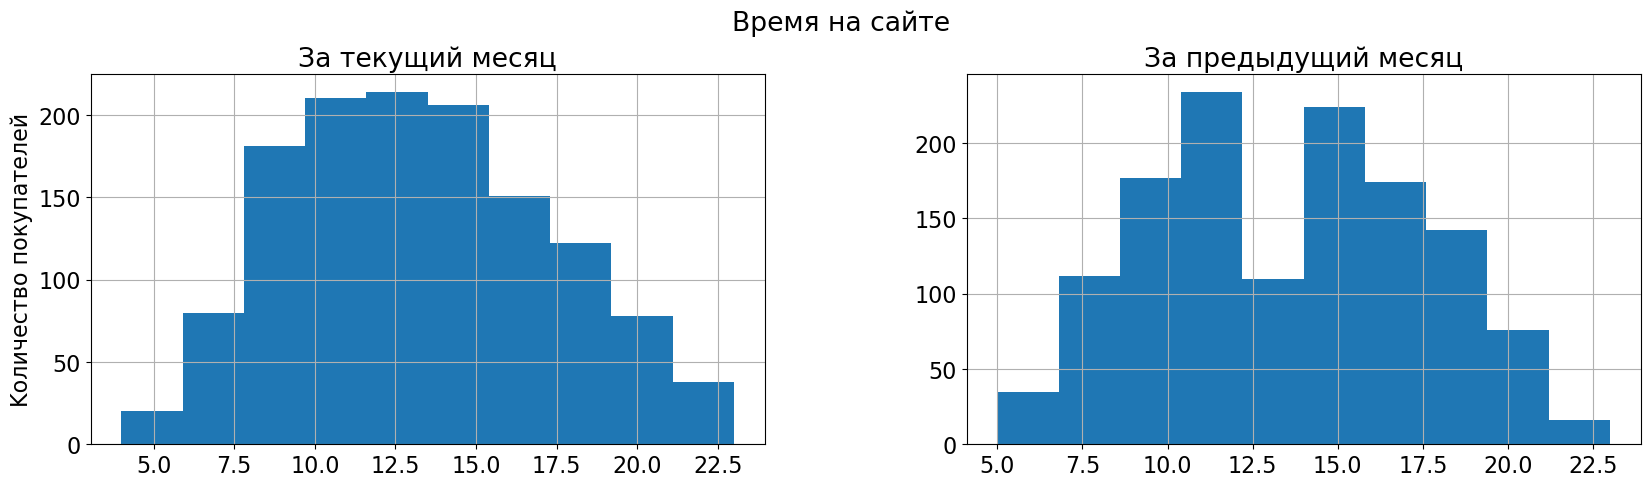

In [39]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

market_time[market_time['Период']=='текущий_месяц'].hist(bins=10,ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('Kоличество покупателей')

market_time[market_time['Период']=='предыдущий_месяц'].hist(bins=10,ax=axs[1])
axs[1].set_title('За предыдущий месяц')

fig.suptitle('Время на сайте')
plt.subplots_adjust(top= 0.85 )
plt.show()

По графикам можно сделать вывод, что за текущий месяц люди провели на сайте больше времени, чем за предыдущий месяц.

### Датасет money

In [40]:
money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


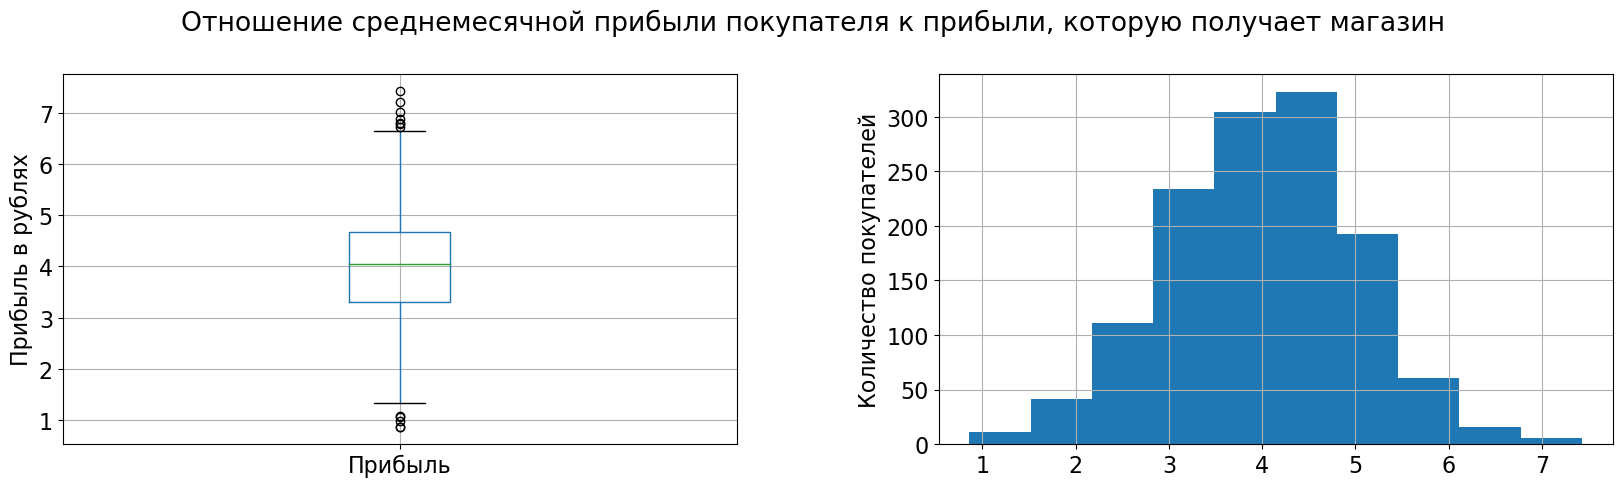

In [41]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

money.boxplot(ax=axs[0])
axs[0].set_ylabel('Прибыль в рублях')

money.hist(bins=10,ax=axs[1])
axs[1].set_ylabel('Количество покупателей')
axs[1].set_title('')

fig.suptitle('Отношение среднемесячной прибыли покупателя к прибыли, которую получает магазин')
plt.subplots_adjust(top= 0.85 )
plt.show()

В среднем магазин получает 4% от дохода покупателя.

### Отбор покупателей.

Будем работать с данными о покупателях, покупательская активность которых не меньше трех месяцев. ДЛя этого исключим из датасета `market_money` покупателей, у которых выручка хотя бы за один период равно нулю.

In [42]:
market_money = market_money.reset_index()

In [43]:
market_money_new = pd.pivot_table(market_money,index='id', columns='Период', values='Выручка')
market_money_new.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [44]:
market_money_new = market_money_new[market_money_new['предыдущий_месяц'] * 
                                    market_money_new['препредыдущий_месяц'] * 
                                    market_money_new['текущий_месяц'] > 0]
market_money_new.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


### Вывод

1. Покупательская активность снизилась у трети покупателей.
2. Количество маркетинговых коммуникаций за текущий месяц было не меньше 3
3. Покупатели разделяются на две группы: те, кто большинство товаров покупают по скидке и те, кто наоборот.
4. Больше всего пользователей заинтересованы в категории "товары для детей".
5. В среднем пользователи тратят около 5000 рублей в магазине за месяц.
6. За текущий месяц люди провели на сайте больше времени, чем за предыдущий месяц.
7. В среднем магазин получает 4% от дохода покупателя.
8. Мы исключили данные о пользователях в датасете `market_money`, покупательская активность которых меньше 3 месяцев. 

<a id='par4'></a> 
## Объединение таблиц

Объединим таблицы `market_file`, `market_money_new` и `market_time`.

In [45]:
market_time = market_time.reset_index()
market_time_new = market_time.pivot_table(index='id', columns='Период', values = 'минут')
market_time_new.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [46]:
market_money_new.columns = ['Пред_мес_выручка','Препред_мес_выручка','Тек_мес_выручка']
market_time_new.columns = ['Пред_мес_время_сайт','Тек_мес_время_сайт']

In [47]:
market_money_new.shape

(1297, 3)

In [48]:
market_time_new.shape

(1300, 2)

In [49]:
market_file.shape

(1300, 12)

In [50]:
market = market_file.merge(market_money_new, how='right', left_index=True, right_index=True)
market = market.merge(market_time_new, how='left', left_index=True, right_index=True)
market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Препред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [51]:
market.shape

(1297, 17)

<a id='par5'></a> 
## Корреляционный анализ

Посмотрим на коэффициенты корреляции покупательской активности с остальными признаками.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Пред_мес_выручка', 'Препред_мес_выручка', 'Тек_мес_выручка', 'Пред_мес_время_сайт', 'Тек_мес_время_сайт']


<Axes: >

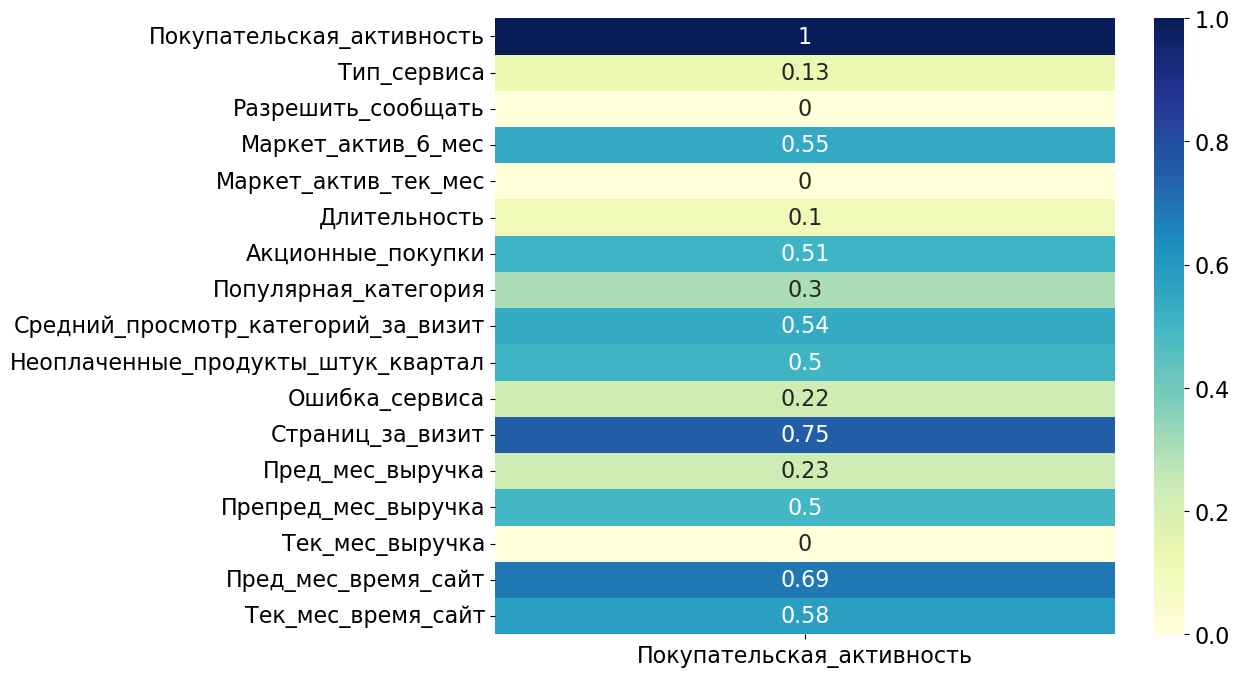

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pd.DataFrame(market.phik_matrix()['Покупательская_активность']), annot=True, cmap='YlGnBu')

Рассчитаем коэффициенты корреляции признаков отдельно для каждого класса целевого признака.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Пред_мес_выручка', 'Препред_мес_выручка', 'Тек_мес_выручка', 'Пред_мес_время_сайт', 'Тек_мес_время_сайт']


Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column


<Axes: >

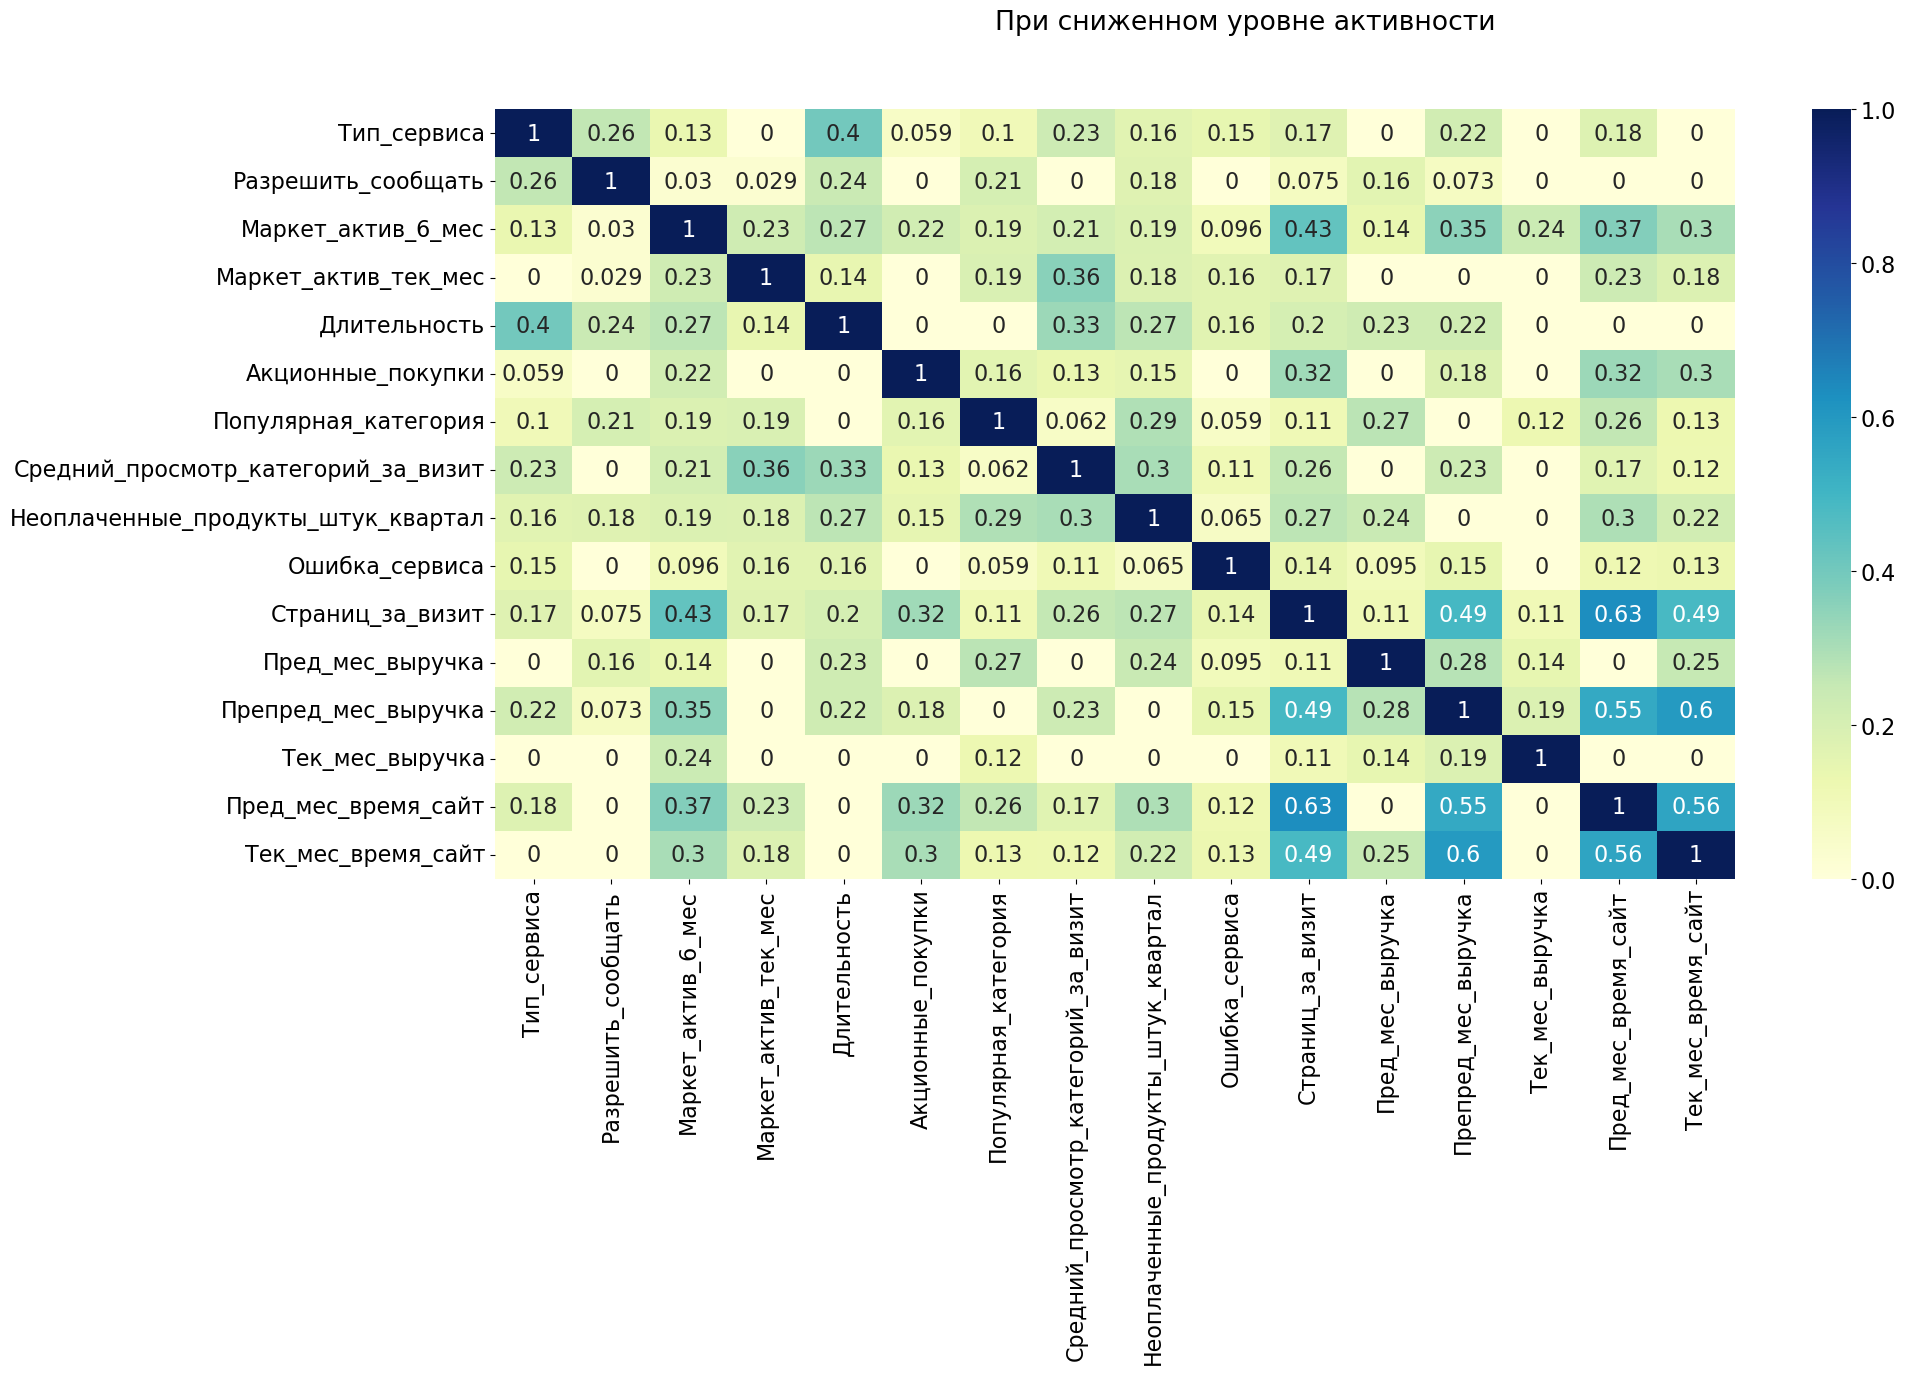

In [53]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('При сниженном уровне активности')
sns.heatmap(market[market['Покупательская_активность']=='Снизилась'].phik_matrix(), annot=True, cmap='YlGnBu')

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Пред_мес_выручка', 'Препред_мес_выручка', 'Тек_мес_выручка', 'Пред_мес_время_сайт', 'Тек_мес_время_сайт']


Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column


<Axes: >

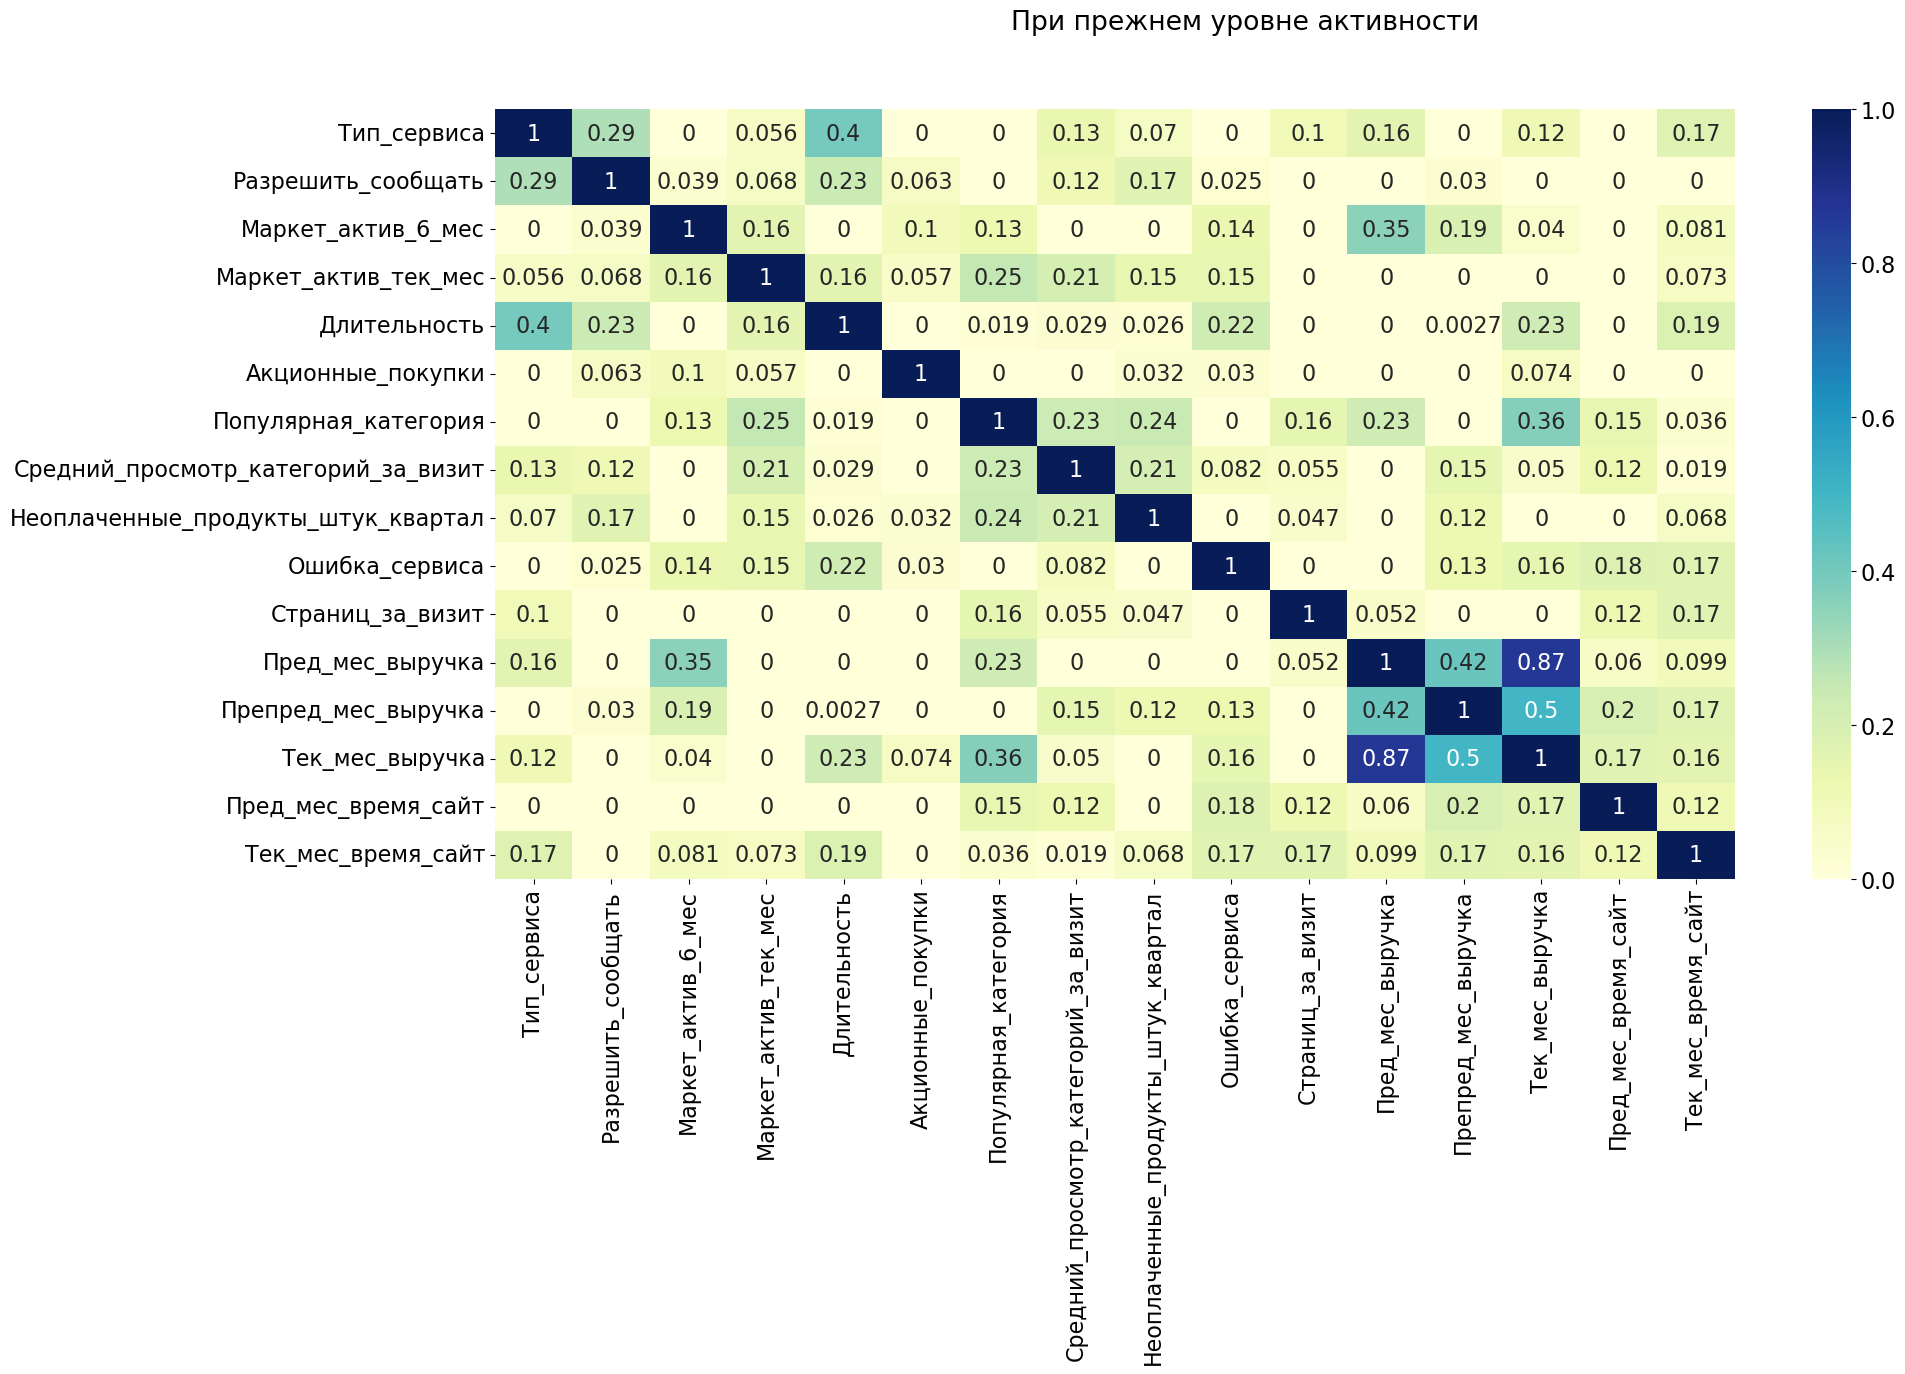

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('При прежнем уровне активности')
sns.heatmap(market[market['Покупательская_активность']=='Прежний уровень'].phik_matrix(), annot=True, cmap='YlGnBu')

**Вывод:** Признак `Покупательская_активность` имеет положительную корреляцию с `Пред_мес_время_сайт`, `Страниц_за_визит`. При сниженном уровне активности можно заметить положительную корреляцию признака `Страниц_за_визит` с `Пред_мес_время_сайт`, при прежнем уровне активности эти признаки не коррелируют. Зато сильно коррелируют `Тек_мес_выручка` и `Пред_мес_выручка`. Это можно назвать мультиколлинеарностью, но удалять данные не стоит, ведь большая корреляция только в одном классе.

<a id='par6'></a> 
## Использование пайплайнов

Сначала закодируем целевой признак. Пусть значение 1 будет, если покупательская активность снизилась, и 0, если осталась на прежнем уровне.

In [55]:
market['Покупательская_активность'] = market['Покупательская_активность'].apply(lambda x: 1 if x=='Снизилась' else 0)
market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Препред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Разделим данные на тренировочную и тестовую выборки с учетом соотношения классов.

In [56]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['Покупательская_активность'], axis=1),
    market['Покупательская_активность'],
    test_size = 0.2, 
    random_state = RANDOM_STATE,
    stratify = market['Покупательская_активность'])

Выделим столбцы для разного типа обработки.

In [57]:
ohe_col = ['Разрешить_сообщать','Тип_сервиса']
ord_col = ['Популярная_категория']
num_col = ['Маркет_актив_6_мес','Длительность',
           'Акционные_покупки','Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит','Маркет_актив_тек_мес',
           'Пред_мес_выручка','Препред_мес_выручка','Тек_мес_выручка','Пред_мес_время_сайт','Тек_мес_время_сайт']

Создадим пайплайн. Добавим в него обработку значений и саму модель.

In [58]:
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))]
    )

ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder())]
)

In [59]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [60]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Будем перебирать несколько моделей и несколько параметров в них для поиска наиболее эффективной.

In [61]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(kernel='linear',random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Разрешить_сообщать',
                                                                                'Тип_сервиса']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder())]),
                                                                               ['Популярная_категория']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['Маркет_ак...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='linear',
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring='roc_auc')

Для оценки работы моделей используется roc auc, так как эта метрика наиболее обще оценивает работу модели, учитывая все возможные пороговые значения.

In [63]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика roc_auc для лучшей модели:
 0.8950135018797223

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Тип_сервиса']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Популярная_категория']),
                                                 (

In [64]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
0,1,"LogisticRegression(penalty='l1', random_state=...",0.895014,"{'preprocessor__num': StandardScaler(), 'model..."
9,2,"LogisticRegression(penalty='l1', random_state=...",0.894876,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,3,"SVC(kernel='linear', random_state=42)",0.892386,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,4,"SVC(kernel='linear', random_state=42)",0.891477,"{'preprocessor__num': StandardScaler(), 'model..."
6,5,KNeighborsClassifier(),0.847502,"{'preprocessor__num': MinMaxScaler(), 'models_..."


**Вывод:** 

Лучше всего работает модель логистической регрессии, для масштабирования количественных признаков использовался MinMaxScaler. Roc auc этой модели равна 0.9. 

<a id='par7'></a> 
## Анализ важности признаков

Проведем анализ важности признаков с помощью значений Шелпи.

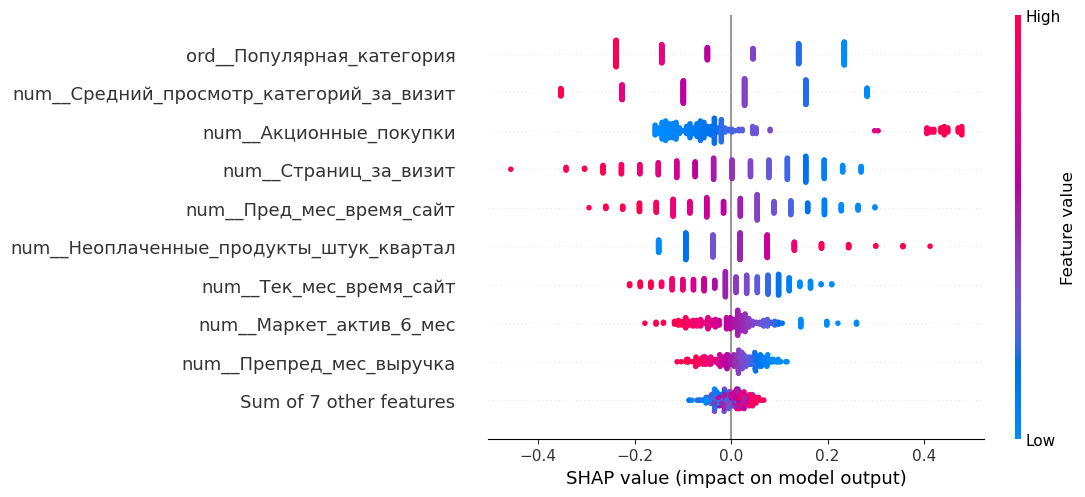

In [65]:
x_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_train)

x_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
x_test = pd.DataFrame(x_test, columns=feature_names)

shap_values = explainer(x_test)

shap.plots.beeswarm(shap_values) 

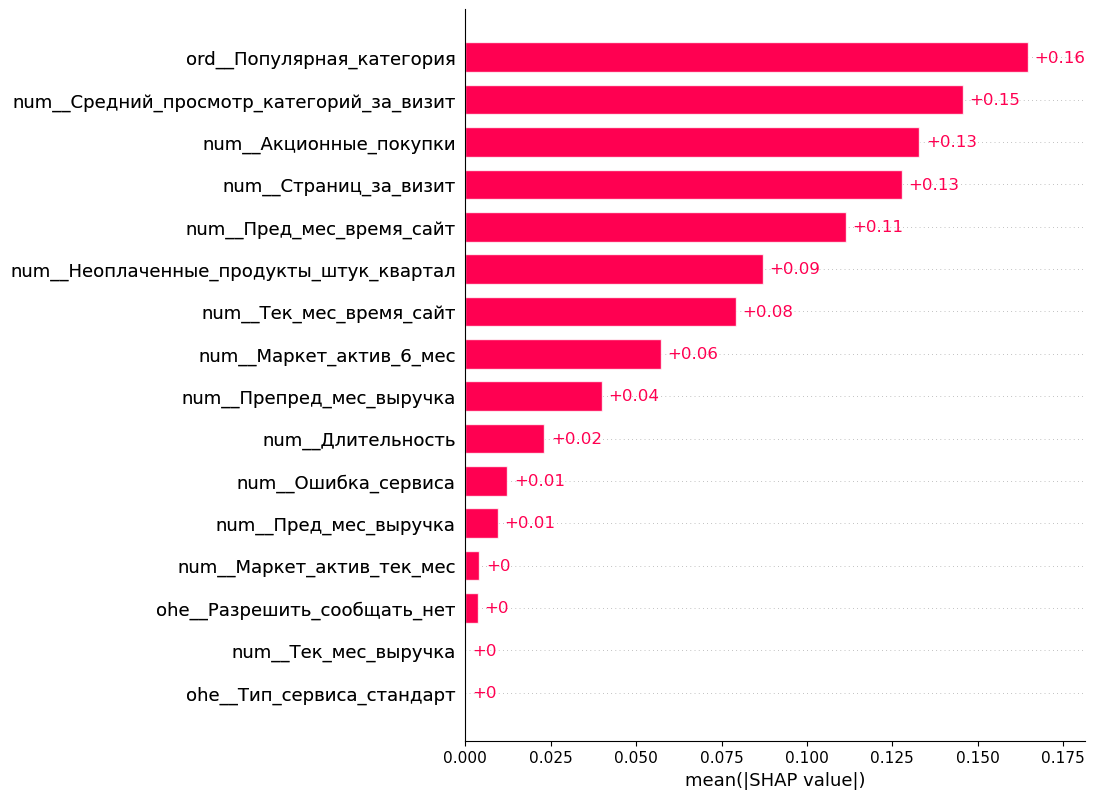

In [66]:
shap.plots.bar(shap_values, max_display=16) 

**Вывод:**

Больше всего на целевой признак влияет признак `Страниц_за_визит`. Чем меньше его значение, тем больше вероятность, что покупательская активность снизилась. Следующие два признака по важности так же связаны с действиями и временем пользователя на сайте. Отсюда можно сделать вывод, что чем меньше покупатель пользуется сайтом, тем ниже его покупательская активность. 
Не влияют на целевой признак значения о типе сервиса,  о том, можно ли присылать покупателю дополнительные предложения о товаре. Также не влияют значения признаков `Маркет_актив_тек_мес`,`Тек_мес_выручка`, однако значения этих признаков за предыдущие месяца достаточно сильно влияют на решение.  

<a id='par8'></a> 
## Сегментация покупателей

Добавим в датасет данные о вероятности снижения покупательской активности и о прибыли.

In [67]:
X_test['Вероятность_снижения'] = randomized_search.predict_proba(X_test)[:,1]

In [68]:
X_test = X_test.reset_index()
X_test.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Препред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения
0,215401,премиум,да,3.4,5,339,0.30,Косметика и аксессуары,2,3,3,4,5548.5,4833.0,6065.9,10,8,0.913114
1,216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,0.089658
2,215700,премиум,да,3.1,4,681,0.27,Косметика и аксессуары,1,5,6,7,4830.5,4559.0,5805.5,10,8,0.954106
3,215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,0.023939
4,215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,0.018878


In [69]:
money = money.reset_index()
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [70]:
for_segm = pd.merge(X_test, money, on='id')
for_segm.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Препред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения,Прибыль
0,215401,премиум,да,3.4,5,339,0.30,Косметика и аксессуары,2,3,3,4,5548.5,4833.0,6065.9,10,8,0.913114,7.43
1,216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,0.089658,5.68
2,215700,премиум,да,3.1,4,681,0.27,Косметика и аксессуары,1,5,6,7,4830.5,4559.0,5805.5,10,8,0.954106,4.59
3,215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,0.023939,5.34
4,215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,0.018878,2.60


Построим график вероятности от прибыли, чтобы выделить группы.

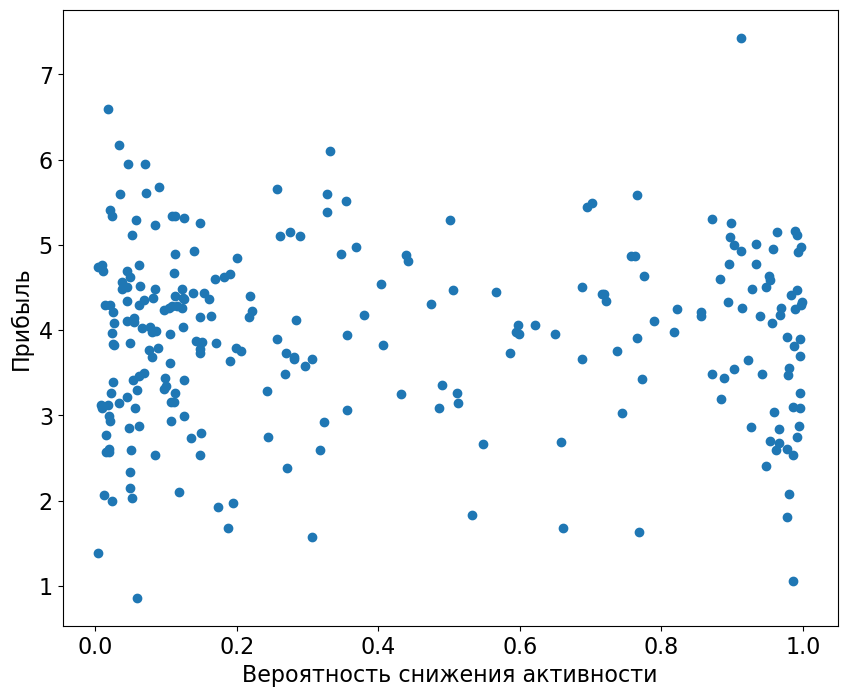

In [71]:
plt.figure(figsize=(10,8))
plt.scatter(x=for_segm['Вероятность_снижения'],y=for_segm['Прибыль'])
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')

plt.show()

Выделим сегмент покупателей, у которых вероятность снижения активности больше 0.6 и прибыль больше 4. Это целевая аудитория, на которую стоит воздействовать, чтобы не потерять прибыль.

In [72]:
segm = for_segm.loc[(for_segm['Вероятность_снижения']>=0.6)&(for_segm['Прибыль']>=4)]
segm_norm = for_segm.loc[(for_segm['Вероятность_снижения']<0.6)]
segm.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Препред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения,Прибыль
0,215401,премиум,да,3.4,5,339,0.30,Косметика и аксессуары,2,3,3,4,5548.5,4833.0,6065.9,10,8,0.913114,7.43
2,215700,премиум,да,3.1,4,681,0.27,Косметика и аксессуары,1,5,6,7,4830.5,4559.0,5805.5,10,8,0.954106,4.59
5,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.967637,4.18
6,215461,стандарт,да,5.6,4,219,0.39,Товары для детей,2,5,2,1,3598.0,4766.0,3700.7,12,9,0.855412,4.21
9,215705,премиум,нет,0.9,4,657,0.99,Домашний текстиль,2,4,2,5,5055.5,4568.0,5522.2,10,7,0.996912,4.30


Анализируя важность признаков на предыдущем шаге, мы выявили наиболее важный. Это `Страниц за визит`. Посмотрим как распределяются значения этого признака на целевом сегменте и сегменте с низкой вероятностью снижения активности.

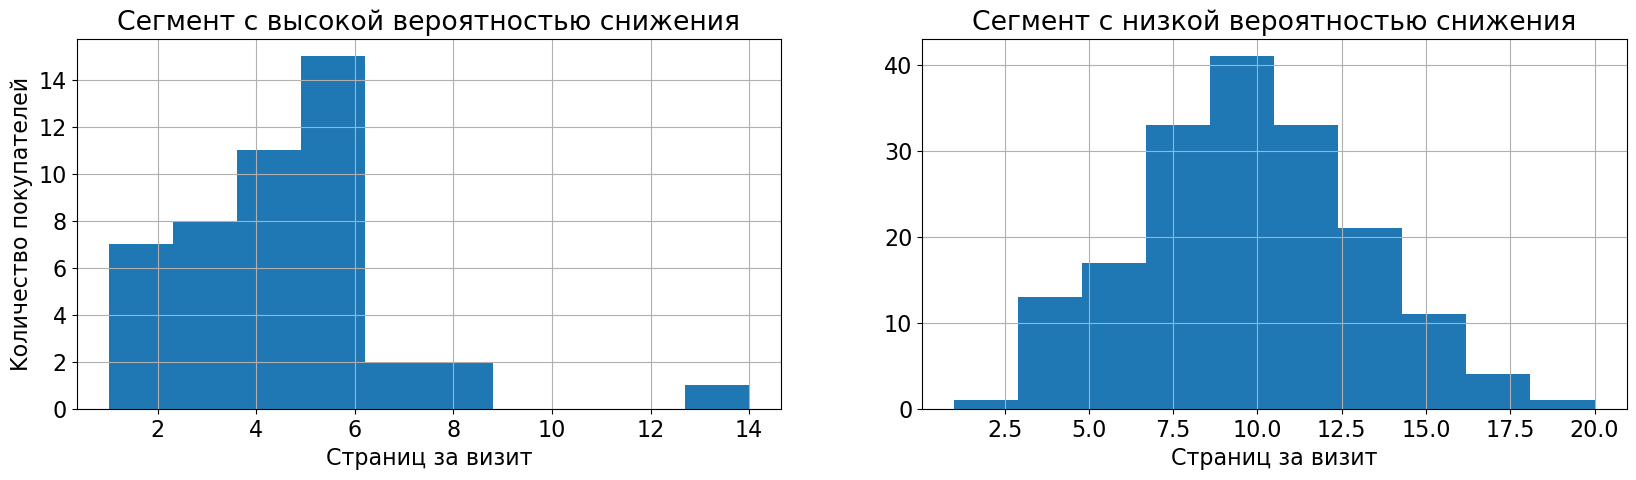

In [73]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

segm['Страниц_за_визит'].hist(ax=axs[0])
axs[0].set_title('Сегмент с высокой вероятностью снижения')
axs[0].set_ylabel('Kоличество покупателей')
axs[0].set_xlabel('Страниц за визит')

segm_norm['Страниц_за_визит'].hist(ax=axs[1])
axs[1].set_title('Сегмент с низкой вероятностью снижения')
axs[1].set_xlabel('Страниц за визит')


plt.subplots_adjust(top= 0.85 )
plt.show()

Заметим, что при высокой вероятности снижения активности, люди посещают меньше страниц сайта.

Посмотрим товары каких категорий покупали чаще всего люди из этого сегмента.

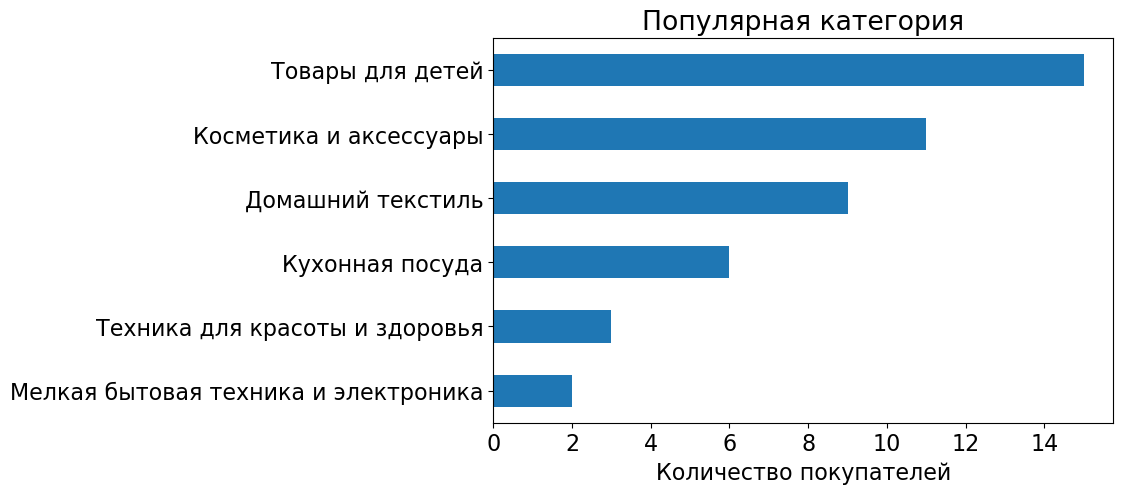

In [74]:
segm['Популярная_категория'].value_counts().sort_values().plot(kind='barh',figsize=(8,5))

plt.title('Популярная категория')
plt.xlabel('Количество покупателей')
plt.show()

Наиболее популярные категории - Товары для детей, Косметика и аксессуары и домашний текстиль.

**Вывод:**

Покупатели, которые приносили большую прибыль, но имеют высокую вероятность снижения покупательской активности, представляют риски для магазина. Таких покупателей стоит удерживать, для этого можно проводить маркетинговые компании, направленные на конкретные категории товаров. Эти товары должны пользоваться популярностью у этих покупателей. В ходе анализа мы выявили такие категории: Товары для детей, Косметика и аксессуары и домашний текстиль. Так же можно привлекать внимание людей на сайте. Сделать хорошую рекламу, проработать дизайн сайта, чтобы людям хотелось проводить больше времени на сайте.

<a id='par9'></a> 
## Общий вывод

Были поставлены задачи построить модель, которая предскажет вероятность снижения покупательской активности клиента, выделить сегменты покупателей и разработать для них персонализированные предложения.

Были предоставлены данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, о выручке, которую получает магазин с покупателя, о времени, которое покупатель провёл на сайте в течение периода и о прибыли покупателя и магазина.

Проведя исследовательский анализ, мы выяснили, что:
1. В данных дисбаланс классов. Покупательская активность снизилась у трети покупателей.
2. Больше всего пользователей заинтересованы в категории "товары для детей".
3. В среднем пользователи тратят около 5000 рублей в магазине за месяц.
4. За текущий месяц люди провели на сайте больше времени, чем за предыдущий месяц.
5. В среднем магазин получает 4% от дохода покупателя.

Далее мы исключили данные о пользователях в датасете market_money, покупательская активность которых меньше 3 месяцев.

При корреляционном анализе, мы узнали, что целевой признак имеет положительную корреляцию с `Пред_мес_время_сайт`, `Страниц_за_визит`. При сниженном уровне активности заметили положительную корреляцию признака `Страниц_за_визит` с `Пред_мес_время_сайт`, при прежнем уровне активности эти признаки не коррелируют. Зато сильно коррелируют `Тек_мес_выручка` и `Пред_мес_выручка`.

Затем мы подготовили данные и подобрали модель. Категориальные признаки обрабатывали с помощью OneHotEncoder, признак `Популярная_категория` обрабатывали, используя OrdinalEncoder. Для масштабирования количественных признаков использовали MinMaxScaler и StandardScaler и выбирали среди них наиболее подходящий. Мы перебирали различные модели, такие как DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC. Лучший результат показала модель логистической регрессии, ее метрика roc auc равна примерно 0.9.  

Больше всего на целевой признак влияет признак `Страниц_за_визит`. Чем меньше его значение, тем больше вероятность, что покупательская активность снизилась. Следующие два признака по важности так же связаны с действиями и временем пользователя на сайте. Отсюда можно сделать вывод, что чем меньше покупатель пользуется сайтом, тем ниже его покупательская активность. Не влияют на целевой признак значения о типе сервиса, о том, можно ли присылать покупателю дополнительные предложения о товаре. Также можно заметить, что у людей которые часто покупают акционные товары больше вероятность снижения активности.

Мы выделили сегмент покупателей, которые приносили большую прибыль, но имеют высокую вероятность снижения покупательской активности, потому что они представляют риски для магазина. Таких покупателей стоит удерживать, для этого можно проводить маркетинговые компании, направленные на конкретные категории товаров. Эти товары должны пользоваться популярностью у этих клиентов. В ходе анализа мы выявили такие категории: Товары для детей, Косметика и аксессуары и домашний текстиль. Так же можно привлекать внимание людей на сайте, ведь чем больше покупатели проводят там времени, тем больше они покупают и заинтересовываются в товарах. Можно сделать хорошую рекламу, проработать дизайн сайта, чтобы людям хотелось проводить больше времени на нем.